# Lossless compression with VAEs
In this notebook, we want to show some practical examples of lossless compression using neural nets, in particular VAEs in 
combination with some techniques demonstrated at some recent ICLR papers.

We will start off with a one-layer VAE in the spirit of https://arxiv.org/abs/1901.04866.

In [1]:
# Modelling
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import math

# Encoding
import constriction

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

## How to build a lossless encoder from a VAE

![Graphical depiction of a VAE](https://miro.medium.com/max/3096/1*Q5dogodt3wzKKktE0v3dMQ@2x.png)
Image taken from https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73.

A VAE is a neural network that consists of two parts, and encoder and a decoder, which are connected through their middle layer, the latent space. Usually, the dimension of the latent space is a lot smaller than the input space and can be interpreted as a lower dimensional representation of the input data x. The job of the encoder is then to transform the input data into the latent space, and the job of the decoder is to transform the latent space representation back to something closely resembling the original image. 

In contrast to a normal Autoencoder, the encoder in the VAE does not produce a latent vector directly, but instead outputs the parameters of a probability distribution over the latents, given x. From this, we can then sample one specific z, and the decoder tries to reconstruct the original x with this sample. Thus, a VAE learns probability distributions over the data. With this framework, we can also view an autoencoder in terms of the probability distributions that they produce:
- encoder: $p(z|x)$
- decoder: $p(x|z)$
- prior:   $p(z)$
Where the prior is given implicitly through the loss function we use when training the VAE. Note that in this framework, we also have to let the decoding network output a probability distribution!

Using these probability distributions, we can employ a simple entropy coding scheme.

## Buildding a VAE
Following https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981

### Setting up model architecture

We use a simple, fully connected neural network, where we orient ourselves at the description for binarized MNIST in the paper by Townsend. Townsend used a FC-FF network with a hidden layer dimension of 100, and a latent dimension of 40. 

For the latent variables, we have a normal distribution $p(z \mid x) = \mathcal{N}(\mu(x), \sigma(x))$, where $\mu, \sigma$ are functions parametrized by the encoder network.

For the output variables, we have Bernoulli Distribution $p(x \mid z) = \text{Ber}(p)$. For regular MNIST, one could use a Beta-Binomial (generalization of a Beta distribution to discrete outputs).

In [2]:
# the negative of log-likelihood for probabilistic output
def nll_loss(x, rv_x):
    return -rv_x.log_prob(x)

class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        # define prior distribution for the code, which is an isotropic Gaussian
        self.prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)   
        self.encoder = self._encoder_z()
        self.decoder = self._decoder_x()

    # Sequential API encoder
    def _encoder_z(self):
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def _decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        layers.append(tfkl.Dense(7*7*32, activation=None))
        layers.append(tfkl.Reshape((7,7,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten(name='x_params'))
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfpl.IndependentBernoulli(self.dim_x, name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        z = self.encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=self.decoder(z))
        model.compile(loss=nll_loss, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model


### Training
We used binarized MNIST.

In [4]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

input_shape = datasets_info.features['image'].shape

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [5]:
### Hyperparams
dim_stochastic = 40
learning_rate = 1e-3
kl_weight = 1.0
training = False

### Training
saved_model_filename = "conv_vae.h5"

if training:
    vae_base = VAE_MNIST(dim_stochastic, kl_weight, learning_rate)
    vae = vae_base.build_vae_keras_model()
    # vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=nll_loss)
    vae.fit(train_dataset, epochs=15, batch_size=128, validation_data=eval_dataset)

    vae.save(saved_model_filename)
else:
    # assumes unchanged stochastic dim etc.
    vae_base = VAE_MNIST(dim_stochastic, kl_weight, learning_rate)
    vae = vae_base.build_vae_keras_model()
    vae.load_weights(saved_model_filename)

### Testing the model

In [6]:
x_sample_batch = next(iter(train_dataset))
x = x_sample_batch[0][0]

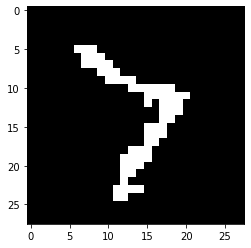

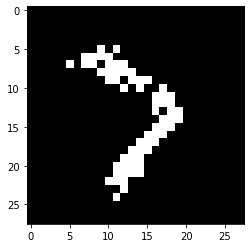

In [7]:
# Let's see a reconstructed number
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x.numpy(), cmap="Greys")
plt.show()
x_ = vae(tf.reshape(x, (1,28,28,1)))
plt.imshow(x_.sample().numpy().reshape(28,28), cmap="Greys")

plt.show()
vae.outputs

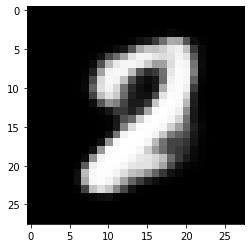

In [8]:
# Plotting a sample from the latent space
z = VAE_MNIST(dim_stochastic, kl_weight, learning_rate).prior.sample(10)
xtilde = vae.get_layer("decoder")(z)
plt.imshow(xtilde.mean()[2].numpy().reshape(28,28), cmap="Greys")
plt.show()

## Building an entropy coding scheme on top

### Discretizing the latent variables
As described in the Townsend paper, we will use a simple static discretization under the prior of the model. This means that we discretize the prior into buckets of equal width. Since the loss function encourages the posterior to stay close to the prior, we will get a discritization of the posterior that in which all buckets also have approximately equal mass.




In [48]:
class DiscretizedRV():
    """Class for discretizing (and transforming back) a Random Variable. Does a maximum entropy discretization
    (divides RV into buckets of equal weight). For this, a CDF and an inverse CDF of the probability distribution are needed"""
    def __init__(self, cdf, inv_cdf, precision_bits = 16):
        if (precision_bits > 16):
            raise ValueError("Discretizing with more than 16 bits would result in very large memory consumption.")
        self.prec = precision_bits
        self.incr = 1/(2**precision_bits)
        self.cdf = cdf
        self.inv_cdf = inv_cdf

    def from_tf_dist(tensorflow_distribution, precision_bits = 16):
        return DiscretizedRV(tensorflow_distribution.cdf, tensorflow_distribution.quantile)
        
    def bins(self):
        """Returns a binned array containing the probability encountering an element in the bin.
        As the bins are designed such that all have equal mass, all elements of this list are the same"""
        return np.array([self.incr] * (2**self.prec))

    def discretize(self, z_cont):
        """Returns the index of the bucket that z_cont lies in."""
        return tf.math.floor(self.cdf(z_cont) / self.incr)

    def undiscretize(self, z_disc):
        """Returns the middle point of the bucket that z_cont lies in"""
        return self.inv_cdf((z_disc + 1/2) * self.incr)

class DiscretizedGaussian(DiscretizedRV):
    """Class for discretizing (and transforming back) a Gaussian Random Variable. Does a maximum entropy discretization
    (divides gaussian into buckets of equal weight)."""
    def __init__(self, mean, std, precision_bits = 16):
        dist = tfd.Normal(mean, std)
        super().__init__(dist.cdf, dist.quantile, precision_bits)

    def _test():
        # just a sanity check
        g = DiscretizedGaussian(-1, 2)
        for i in range(100):
            x = np.random.uniform(-4,4)
            x_ = g.undiscretize(g.discretize(x))
            assert abs(x - x_) < 1e-3, f"{x} != {x_}"
        print("Discretized Gaussian test passed.")

DiscretizedGaussian._test()

Discretized Gaussian test passed.


In [49]:
xtilde.log_prob(x_sample_batch[0][:10])


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-339.45044, -192.47545, -312.13647, -366.28107, -271.27493,
       -259.05087, -376.12195, -469.6767 , -841.4579 , -343.11615],
      dtype=float32)>

### Encoding messages using the VAE 
We use an ANS-Coder implemented by Prof. Bamlers [Constriction libary](https://pypi.org/project/constriction/).

As explained, we will use the VAE to parameterize get our likelihood $p(x \mid z)$, posterior $p(z\mid x)$ and prior $p(z)$. 

To use these values with an ANS coder, we need to discretize all variables and need to provide probabilities tables. 

To make the encoding tractable, we impose an independency assumption on the output pixels given the latent variable (as this is how our model is built). This means, that the likelihood factorizes: 

\begin{equation*}
p(x\mid z) = \prod_i p(x_i \mid z) 
\end{equation*}

This requirement is necessary for the ANS-Coder. We can then just encode all pixels $x_i$ onto the encoder with their respective likelihoods $p(x_i \mid z)$. Note, that the VAE outputs Bernouilli RVs, which means that that the likelihood is just equal to the parameter of the Bernoulli in the output layer of the generative network. Similarly, the VAE architecture itself (at least how we implemented it here) assumes an independency on the prior and posterior, so we also have

\begin{equation*}
p(z) = \prod_i p(z_i) \\
p(z\mid x) = \prod_i p(z_i \mid x)
\end{equation*}

Which also allows us to push the z independently on the encoder stack.

2097152000 1107296256  273158208 1996488704
 1108951451  423910263          0 2960698160  218103808          0
 2960698160  218103808 2109300850 1107296256  483689536 1728053247
 3003121663  167772159 4294967295 3054633838   16777216          0
 4233378800  134217727 4294967295 4294967295 4294967295  520093696
 1752199712  201326591 4294967295 4294967295 4294967295  136199132
        146]
[1476395007  251658239   33666562 4195582491  201326591 4294967295
 4294967295 4294967295   16777216 2449473536  181806709 4294967295
 4294967295 4294967295  117440512  603979776  189019772 4294967295
 3658746002   33554432          0 1718409135  251658240   67108864
 2449473536  239232196          0          0          0 1913462387
  503316480  218103808 2097152000 1107296256  474113571 1621826760
 2952790016  218103808 2097152000 1107296256  273158208 1996488704
 1108951451  423910263          0 2960698160  218103808          0
 2960698160  218103808 2109300850 1107296256  483689536 1728053247
 3003

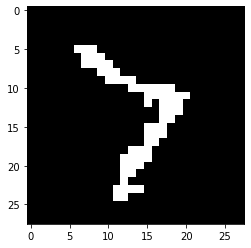

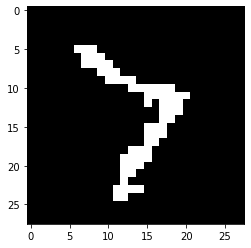

In [202]:
def get_pixel_probs(bernoulli_layer):
    return tf.squeeze(bernoulli_layer.parameters["distribution"].parameters["distribution"].probs_parameter())

enc   = vae_base.encoder
dec   = vae_base.decoder
prior = vae_base.prior

z_dist = enc(tf.reshape(x, (1,28,28,1)))
z_sample = z_dist.sample()

# Showing how to encode z on the stack
coder = constriction.stream.stack.AnsCoder()
Z_discretizer = DiscretizedRV.from_tf_dist(prior)
z_bins = Z_disc.bins()
z_sample_disc = tf.cast(Z_disc.discretize(tf.reshape(z_sample, (40,1))), tf.int32).numpy()
coder.encode_iid_categorical_symbols_reverse(z_sample_disc, 0, z_bins)
print(f"length of compressed z (prior) {coder.get_compressed() * 32}")

# Showing how to decode z on the stack
z_sample_disc_dec = coder.decode_iid_categorical_symbols(40, 0, z_bins)
assert np.all(z_sample_disc == z_sample_disc_dec)

# Encoding x | z on the stack
x_hat_dist = dec(tf.reshape(z_sample_disc, (1,40)))
x_hat_probs_flat = tf.reshape(get_pixel_probs(x_hat_dist), -1)

for i, pixel in enumerate(tf.reshape(x, -1)):
    value = np.array([int(pixel.numpy())], dtype=np.int32)
    p = x_hat_probs_flat[i].numpy()
    coder.encode_iid_categorical_symbols_reverse(np.array(value, dtype=np.int32), 0, np.array([1-p, p]))

print(f"length of compressed x | z {coder.get_compressed() * 32}")

# Decoding x | z
x_dec = np.zeros(28*28)
for i in range(28*28):
    p = x_hat_probs_flat[28*28 - i - 1].numpy()
    x_dec[i] = coder.decode_iid_categorical_symbols(1, 0, np.array([1-p, p]))

x_dec = np.flip(x_dec.reshape((28,28)))

# Examining both
plt.imshow(x_dec, cmap="Greys")
plt.show()
plt.imshow(x, cmap="Greys")
plt.show()

assert np.all(tf.squeeze(x).numpy() == x_dec)